In [84]:
import numpy as np
import matplotlib.pyplot as plt

params = {
    'PI' : np.pi,
    'ALPHA' : 0.1,
    'a' : 1,
    'H' : 81,
    'r0' : 1.5,
    'R' : 57.5,
    'RHO' : 1.225,
    'ZETA' : 0.6,
    'ZETA2' : 0.45,
    'ZETA3' : 0.9,
    'OMEGAn' : 11.11,
    'OMEGAn2' : 5.73,
    'OMEGAn3' : 3.42
}


In [85]:
class WindShearModel:
    def __init__(self, **params):

        self.PI = params['PI'] 
        self.ALPHA = params['ALPHA'] 
        self.H = params['H'] 
        self.r0 = params['r0'] 
        self.R = params['R'] 
        self.RHO = params['RHO'] 
        self.ZETA = params['ZETA'] 
        self.ZETA2 = params['ZETA2'] 
        self.ZETA3 = params['ZETA3'] 
        self.OMEGAn = params['OMEGAn'] 
        self.OMEGAn2 = params['OMEGAn2'] 
        self.OMEGAn3 = params['OMEGAn3'] 

    def Vws(self, THETA, Vm=10):
        R = self.R
        r0 = self.r0
        ALPHA = self.ALPHA
        H = self.H
        THETAS = [THETA, THETA + (2*self.PI/3), THETA + (4*self.PI/3)]
        Xs = [np.cos(THETAS[i]) for i in range(len(THETAS))]
        vws = np.array([])
        for X in Xs:
            p1 = (2*Vm/(3*R**2)) * ((ALPHA*X*R**3/(3*H)) + ((R**4)*ALPHA*(ALPHA-1)*(X**2)/(4*2*(H**2))))
            p2 = (2*Vm/(3*R**2)) * ((R**5)*((ALPHA**2)-ALPHA)*(ALPHA-2)*(X**3)/(5*6*H**3))
            v = p1 + p2
            vws = np.append(vws,v)
        return vws

In [86]:
wsm = WindShearModel(**params)
angs = np.linspace(0,np.pi*2,100)
vws_ = []
for ang in angs:
    vws = wsm.Vws(THETA=ang)
    vws_.append(vws)
vws_ = np.array(vws_).T

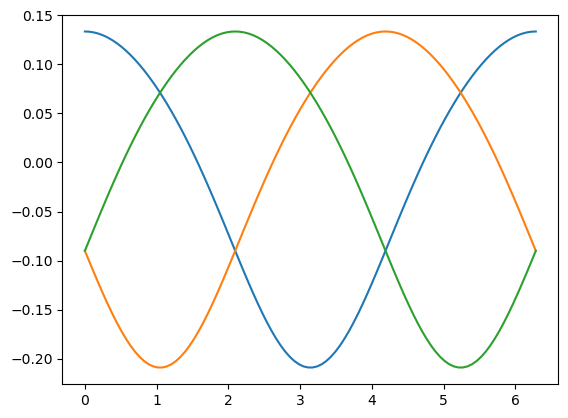

In [87]:
for v in vws_:
    plt.plot(angs,v)

In [ ]:
class TowerShadowModel:
    def __init__(self, **params):

        self.PI = params['PI'] 
        self.ALPHA = params['ALPHA'] 
        self.H = params['H'] 
        self.r0 = params['r0'] 
        self.R = params['R'] 
        self.a = params['a'] 
        self.RHO = params['RHO'] 
        self.ZETA = params['ZETA'] 
        self.ZETA2 = params['ZETA2'] 
        self.ZETA3 = params['ZETA3'] 
        self.OMEGAn = params['OMEGAn'] 
        self.OMEGAn2 = params['OMEGAn2'] 
        self.OMEGAn3 = params['OMEGAn3'] 

    def Vts(self, THETA, Vm=10):
        R = self.R
        a = self.a
        r0 = self.r0
        ALPHA = self.ALPHA
        H = self.H
        THETAS = [THETA, THETA + (2*self.PI/3), THETA + (4*self.PI/3)]

        PSI = 2*(a**2)*((R**2)-(r0**2))/(((R**2)-(r0**2)))
        Xs = [np.cos(THETAS[i]) for i in range(len(THETAS))]
        vts = np.array([])
        for X in Xs:
            p1 = (2*Vm/(3*R**2)) * ((ALPHA*X*R**3/(3*H)) + ((R**4)*ALPHA*(ALPHA-1)*(X**2)/(4*2*(H**2))))
            p2 = (2*Vm/(3*R**2)) * ((R**5)*((ALPHA**2)-ALPHA)*(ALPHA-2)*(X**3)/(5*6*H**3))
            v = p1 + p2
            vts = np.append(vts,v)
        return vts